# Assignment 7

## 2. Beta and expected returns

### a)

In [80]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
db = wrds.Connection()
db.create_pgpass_file()

Loading library list...
Done
Enter your WRDS username [jonkq]:jonkq
Enter your password:········


In [3]:
# get rf
rf=db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='1980-01-01' and mcaldt<='2019-12-31'")
rf.to_csv('rf.csv')
# get value-weighted CRSP market return
vwret = db.raw_sql("select date, vwretd from crsp.msi where date>='1980-01-01' and date<='2019-12-31'")
vwret.to_csv('vwret.csv')

In [4]:
rf = pd.read_csv('rf.csv', usecols=['tmytm']).squeeze()
#Compute the monthly simple rate
rf_m = np.exp(rf/12/100)-1

vwret = pd.read_csv('vwret.csv', usecols=['vwretd']).squeeze()

In [5]:
stocks = db.raw_sql("""
                select a.permno, a.date, a.ret, b.exchcd, b.shrcd, a.shrout, a.prc 

                from crsp.msf as a left join crsp.msenames as b 
                
                on a.permno = b.permno and b.namedt <= a.date and a.date<=b.nameendt
                
                where a.date between '1980-01-01' and '2019-12-31'
                and b.exchcd between 1 and 2
                and b.shrcd between 10 and 11""",date_cols=['date'])

stocks.to_csv('stocks.csv')

### b)

In [8]:
stocks_df = pd.pivot_table(data=stocks, values='ret', index='date', columns='permno')

In [36]:
s = stocks_df.apply(sum)

In [37]:
s = list(s.isna())

In [43]:
s_i = []
for i in range(len(s)):
    if not s[i]:
        s_i.append(i)

In [46]:
stocks_df = stocks_df.iloc[:,s_i]

In [50]:
vwret_e = vwret - rf_m

In [53]:
stocks_e = stocks_df - rf_m

In [70]:
rf_m.index = stocks_df.index
stocks_e = stocks_df.subtract(rf_m, axis = 0)

In [106]:
N = stocks_e.shape[1]
betas = []
x = np.array(vwret_e).reshape((-1,1))

for i in range(N):
    y = np.array(stocks_e.iloc[:,i]).reshape((-1,1))
    lm = LinearRegression().fit(x,y)
    betas.append(lm.coef_.item())

In [191]:
betas_ord = list(np.argsort(betas))
betas_sort = list(np.sort(betas))

stocks_avg = np.array(stocks_df.apply(np.mean))
stocks_avg_sort = stocks_avg[betas_ord]

In [158]:
beta_pfs = [betas_sort[i*27:(i+1)*27] for i in range(10)]
beta_pfs[9].append(betas_sort[N-1])

In [161]:
stocks_avg_sort_pfs = [stocks_avg_sort[i*27:(i+1)*27] for i in range(10)]
stocks_avg_sort_pfs[9] = np.append(stocks_avg_sort_pfs[9], stocks_avg_sort[N-1])

In [162]:
stocks_avg_sort_pfs_m = []
beta_pfs_m = []
for i in range(10):
    stocks_avg_sort_pfs_m.append(np.mean(stocks_avg_sort_pfs[i]).item())
    beta_pfs_m.append(np.mean(beta_pfs[i]).item())

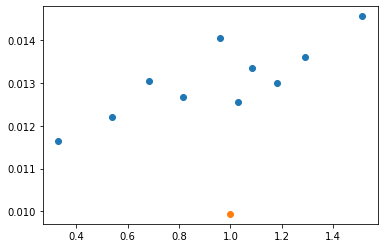

In [163]:
plt.scatter(beta_pfs_m, stocks_avg_sort_pfs_m)
plt.scatter(1, np.mean(vwret))

The fitted line (Security Market Line) between the blue points (portfolios) would not go through the orange point (market). This is not consistent with CAPM since CAPM states that all points should lie on the SML.

### c)

In [182]:
stocks1 = stocks_df.iloc[:12*19+12,:]
stocks2 = stocks_df.iloc[12*19+12:,:]
vwret1 = vwret.iloc[:12*19+12]
vwret2 = vwret.iloc[12*19+12:]

In [184]:
betas1 = []
betas2 = []
x1 = np.array(vwret1).reshape((-1,1))
x2 = np.array(vwret2).reshape((-1,1))

for i in range(N):
    y1 = np.array(stocks1.iloc[:,i]).reshape((-1,1))
    y2 = np.array(stocks2.iloc[:,i]).reshape((-1,1))
    lm1 = LinearRegression().fit(x1,y1)
    lm2 = LinearRegression().fit(x2,y2)
    betas1.append(lm1.coef_.item())
    betas2.append(lm2.coef_.item())

In [186]:
betas1_ord = list(np.argsort(betas1))
betas2_ord = list(np.argsort(betas2))
betas1_sort = list(np.sort(betas1))
betas2_sort = list(np.sort(betas2))

stocks1_avg = np.array(stocks1.apply(np.mean))
stocks2_avg = np.array(stocks2.apply(np.mean))

In [188]:
beta1_pfs = [betas1_sort[i*27:(i+1)*27] for i in range(10)]
beta1_pfs[9].append(betas1_sort[N-1])
beta2_pfs = [betas2_sort[i*27:(i+1)*27] for i in range(10)]
beta2_pfs[9].append(betas2_sort[N-1])

In [190]:
stocks2_avg_sort = stocks2_avg[betas1_ord]